In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from Levenberg_Marquardt import LevenbergMarquardt, Loss
from tqdm import tqdm

In [16]:
# Define functions for finding the optimal dividing surface
def q(X, y, w):
    d = np.size(X, axis=1)
    d2 = d * d
    W = np.reshape(w[:d2], (d, d))
    v = w[d2 : d2 + d]
    b = w[-1]
    qterm = np.diag(X @ W @ np.transpose(X))
    return y * qterm + (np.outer(y, np.ones((d,))) * X) @ v + y * b

def logloss_quadratic(X, y, w):
    return 0.5 * np.sum(np.log(1 + np.exp(-q(X, y, w)))**2)

def Res_and_Jac(X, y, w):
    # the vector of residuals r
    aux = np.exp(-q(X, y, w))
    r = np.log(1 + aux)
    # the Jacobian matrix J[i,j] = dr[i]/dx[j]
    a = -aux / (1 + aux)
    n,d = np.shape(X)
    d2 = d * d
    ya = y * a
    qterm = np.zeros((n, d2))
    for k in range(n):
        xk = X[k, :]
        xx = np.outer(xk, xk)
        qterm[k, :] = np.reshape(xx, (np.size(xx),))
    J = np.concatenate((qterm, X, np.ones((n, 1))), axis=1)
    for k in range(n):
        J[k, :] = J[k, :] * ya[k]
    return r, J

In [17]:
def plot_loss_and_grad(loss, norm_grad_loss):
  fig, (ax1, ax2) = plt.subplots(2, 1)

  ax1.plot(loss)
  ax1.set_xlabel('Iteration #')
  ax1.set_ylabel('Loss')
  ax1.set_yscale('log')

  ax2.plot(norm_grad_loss)
  ax2.set_xlabel('Iteration #')
  ax2.set_ylabel('||grad Loss||')
  ax2.set_yscale('log')

  plt.tight_layout()
  plt.show()

In [18]:
# Read mnist data from the mat file
mnist_data = scipy.io.loadmat('mnist2.mat')
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])

d1, d2, N = np.shape(imgs_train)

In [19]:
# Select images of 1 and 7
Itrain_1 = np.where(labels_train == 1)
Itrain_7 = np.where(labels_train == 7)
Itest_1 = np.where(labels_test == 1)
Itest_7 = np.where(labels_test == 7)
imgs_train_1 = np.squeeze(imgs_train[:,:,Itrain_1])
imgs_train_7 = np.squeeze(imgs_train[:,:,Itrain_7])
imgs_test_1 = np.squeeze(imgs_test[:,:,Itest_1])
imgs_test_7 = np.squeeze(imgs_test[:,:,Itest_7])
Ntrain_1 = np.size(Itrain_1)
Ntrain_7 = np.size(Itrain_7)
Ntest_1 = np.size(Itest_1)
Ntest_7 = np.size(Itest_7)

In [20]:
dd = d1 * d2

# Prepare the train set
X1_train = np.zeros((Ntrain_1, dd))
for j in range(Ntrain_1):
    img = np.squeeze(imgs_train_1[:, :, j])
    X1_train[j, :] = np.reshape(img, (dd,))

X7_train = np.zeros((Ntrain_7, dd))
for j in range(Ntrain_7):
    img = np.squeeze(imgs_train_7[:, :, j])
    X7_train[j, :] = np.reshape(img, (dd,))

X_train = np.concatenate((X1_train, X7_train), axis=0)
U, S, Vtrans = np.linalg.svd(X_train, full_matrices=False)
V = np.transpose(Vtrans)

# Prepare the test set
X1_test = np.zeros((Ntest_1, dd))
for j in range(Ntest_1):
    img = np.squeeze(imgs_test_1[:, :, j])
    X1_test[j, :] = np.reshape(img, (dd,))

X7_test = np.zeros((Ntest_7, dd))
for j in range(Ntest_7):
    img = np.squeeze(imgs_test_7[:, :, j])
    X7_test[j, :] = np.reshape(img, (dd,))

X_test = np.concatenate((X1_test, X7_test), axis=0)

In [21]:
# prepare labels for the train and test sets: ones have label 1, sevens have label -1
Ntrain = Ntrain_1 + Ntrain_7
Ntest = Ntest_1 + Ntest_7
lbl_train = np.ones((Ntrain,))
lbl_train[Ntrain_1:] = -1
lbl_test = np.ones((Ntest,))
lbl_test[Ntest_1:] = -1

### Task 1 (PCA)

In [ ]:
# Use PCA to reduce the dimensionality to NPCA
def pca_misclassified(Algorithm, d, X_train, X_test, y_train, y_test, plot=False):
    X_train_pca = X_train @ V[:, :d]
    X_test_pca = X_test @ V[:, :d]

    # Call Levenberg-Marquardt
    def r_and_J(w):
        return Res_and_Jac(X_train_pca, y_train, w)

    # The quadratic surface is of the form x^\top W x + v x + b
    # The total number of parameters in W, v, b is d^2 + d + 1
    # The initial guess: all parameters are ones
    w = np.ones((d * d + d + 1,))
    iter_max = 600
    tol = 1e-3
    w, Loss_vals, gradnorm_vals = Algorithm(r_and_J, w, iter_max, tol)

    # Plot the loss function and the norm of its gradient
    if plot:
        plot_loss_and_grad(Loss_vals, gradnorm_vals)

    # Apply the learned classifier to the test set
    test = q(X_test_pca, y_test, w)
    misses = np.argwhere(test < 0)
    return len(misses)

In [23]:
misclassified = []
npcas = range(5, 30, 5)
for npca in tqdm(npcas):
  misclassified.append(pca_misclassified(LevenbergMarquardt, npca, X_train, X_test, lbl_train, lbl_test))

100%|██████████| 5/5 [04:14<00:00, 50.94s/it]


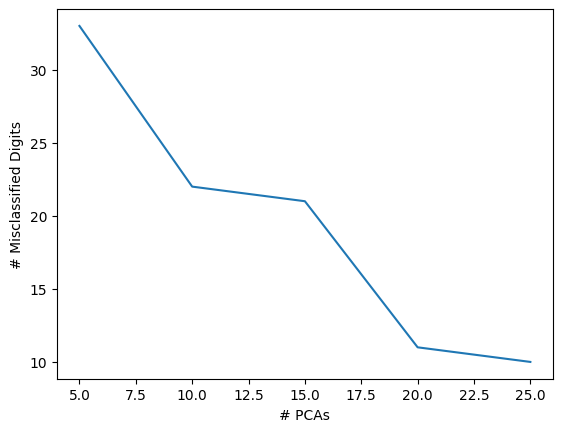

In [ ]:
plt.plot(npcas, misclassified)
plt.xlabel('# PCAs')
plt.ylabel('# Misclassified Digits')
plt.show()

### Task 2 (Gauss-Newton)

In [ ]:
def GaussNewton(Res_and_Jac, w, ITER_MAX, TOL):
  losses = []
  grad_norms = []

  iter = 1
  while iter < ITER_MAX:
    r, J = Res_and_Jac(w)
    grad = J.T @ r
    losses.append(Loss(r))
    grad_norms.append(np.linalg.norm(grad))

    if grad_norms[-1] < TOL:
      break

    p = np.linalg.solve(J.T @ J + np.eye(len(w)) * 1e-6, -grad)
    w += p
    iter += 1
  return w, losses, grad_norms

(421,)


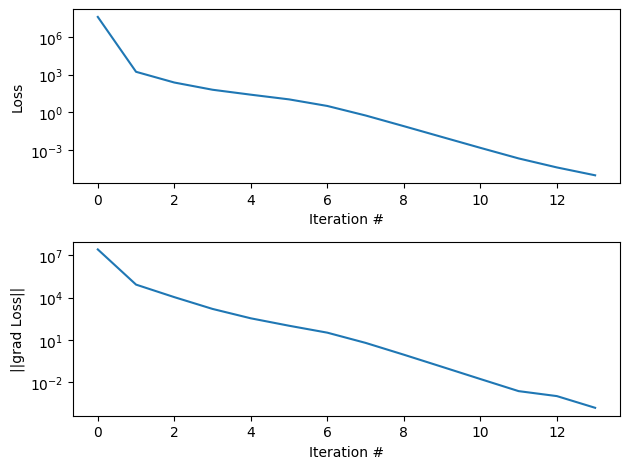

20

In [25]:
pca_misclassified(GaussNewton, 20, X_train, X_test, lbl_train, lbl_test, plot=True)

### Task 3 (Stochastic Gradient Descent)

In [159]:
def myloss(r, w):
    lambd = 1e-3
    return np.mean(r) + lambd / 2 * np.linalg.norm(w)**2

def StochasticGradientDescent(Res_and_Jac, w, ITER_MAX, TOL, BATCH_SIZE=300):
  losses = []
  grad_norms = []

  iter = 1
  while iter < ITER_MAX:
    r, J = Res_and_Jac(w)
    N = len(r)
    xi = np.random.choice(N, BATCH_SIZE)
    g = J[xi, :].T @ r[xi] / BATCH_SIZE
    alpha = 5 * 1e-3 # Constant stepsize, 25 misclassified
    losses.append(myloss(r, w))
    grad_norms.append(np.linalg.norm(g))
    print(f'iter={iter} loss={losses[-1]} ||g||={grad_norms[-1]}')

    if grad_norms[-1] < TOL:
      break

    w = w - alpha * g
    iter += 1
  return w, losses, grad_norms

iter=1 loss=40.76766349227946 ||g||=2152.5469129710323
iter=2 loss=51.5753370614839 ||g||=2094.9129014562163
iter=3 loss=5.492747050161172 ||g||=178.91709572809415
iter=4 loss=3.725737814414502 ||g||=149.57718377290584
iter=5 loss=2.6363086544714522 ||g||=50.50649545686408
iter=6 loss=2.371619068179556 ||g||=25.81782309068132
iter=7 loss=2.2844392013996715 ||g||=69.20177949127631
iter=8 loss=1.9777591817695195 ||g||=32.65835967996637
iter=9 loss=1.8672793632964595 ||g||=20.307158973673673
iter=10 loss=1.798071914779843 ||g||=39.544061617850836
iter=11 loss=1.6750707988575793 ||g||=56.89016681177616
iter=12 loss=1.5228255341448054 ||g||=22.003231402822845
iter=13 loss=1.4837846187449533 ||g||=26.75735633413143
iter=14 loss=1.4443421438851074 ||g||=37.49200289315148
iter=15 loss=1.3712514755474878 ||g||=38.31787870349424
iter=16 loss=1.3033921571325147 ||g||=30.45071195239919
iter=17 loss=1.271234086530066 ||g||=77.08227951976568
iter=18 loss=1.156690623191891 ||g||=55.20476448620806
ite

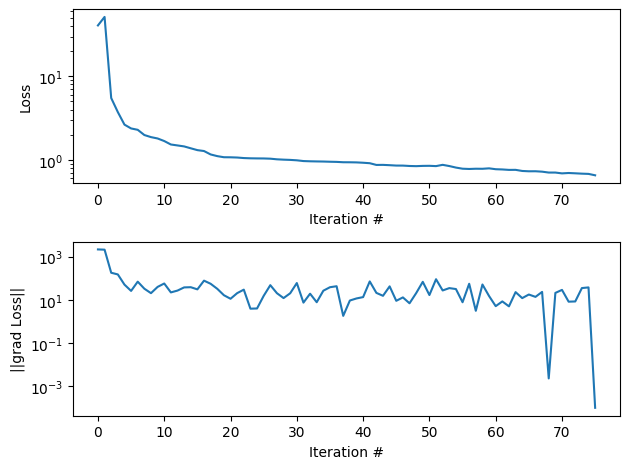

28

In [160]:
pca_misclassified(StochasticGradientDescent, 20, X_train, X_test, lbl_train, lbl_test, plot=True)